In [2]:
using Revise
includet("../../scripts/single_influx.jl")

┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Symbolics → SymbolicsForwardDiffExt
│  └─ Symbolics → SymbolicsPreallocationToolsExt
│ Precompilation will also be skipped for the following, which depend on the above cycle:
│   SSMC
│   MLSolver
└ @ Pkg.API.Precompilation ~/.julia/juliaup/julia-1.10.10+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/precompilation.jl:583
Precompiling packages...
  19404.5 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 28 seconds. 539 already precompiled. 4 skipped due to circular dependency.


In [3]:
using ProgressMeter
using ColorSchemes
using UnPack

In [4]:
includet("../../scripts/figures_util.jl")

using GLMakie
using CairoMakie
CairoMakie.activate!()

# Plotting proportions

## Setup

In [5]:
function plot_binom_sample!(ax, xs, ns, num_repeats;
    label="",
    proportions=false,
    kwargs...
)
    if isa(num_repeats, Number)
        num_repeats = fill(num_repeats, length(ns))
    end

    xx = if proportions
        ns ./ num_repeats
    else
        ns
    end
    sl = scatterlines!(ax, xs, xx;
        label,
        kwargs...
    )

    mins = Float64[]
    maxs = Float64[]
    @show proportions
    for (n, nrs) in zip(ns, num_repeats)
        bt = BinomialTest(n, nrs)
        ci = confint(bt; method=:wilson)
        if proportions
            push!(mins, ci[1])
            push!(maxs, ci[2])
        else
            push!(mins, ci[1] * nrs)
            push!(maxs, ci[2] * nrs)
        end
    end

    b = band!(ax, xs, mins, maxs;
        alpha=0.5,
        kwargs...
    )

    (sl, b)
end

function plot_cdf1!(ax, cdf; include_bad=true, proportions=false)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct",
        color=PaperColors.extinct1(),
        proportions
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable",
        color=PaperColors.unstable1(),
        proportions
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable",
        color=PaperColors.stable1(),
        proportions
    )
    if include_bad
        p3 = plot_binom_sample!(ax, cdf.K, cdf.bad_ss .+ cdf.good_ss_bad_ls, cdf.num_runs;
            label="bad data",
            color=PaperColors.other(),
            proportions
        )
    end
    (p1, p2, p3)
end
function plot_cdf1(cdf; kwargs...)
    f = Figure()
    ax = Axis(f[1, 1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf; kwargs...)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

function plot_df1(df)
    f = Figure(;
    # size=(800, 500)
    )

    ax_biom = Axis(f[1, 1:2];
        ylabel="HSS biomass",
        yscale=Makie.pseudolog10,
        # yscale=Makie.log10,
        xscale=log10,
    )
    ax2 = Axis(f[2, :];
        ylabel="observed MRL",
        xscale=log10,
    )
    ax3 = Axis(f[3, :];
        ylabel="MRL at K=0",
        xscale=log10,
    )
    ax4 = Axis(f[4, 1];
        ylabel="Counts",
        xscale=log10,
    )
    linkxaxes!(ax_biom, ax4)
    linkxaxes!(ax2, ax4)
    linkxaxes!(ax2, ax4)
    for ax in [ax_biom, ax2, ax3]
        hidexdecorations!(ax;
            grid=false,
            ticks=false,
        )
    end
    ax4.xlabel = "K"

    xx = @subset df :good_ss
    # scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
    scatter!(ax_biom, xx.K, xx.hss_biomass)

    scatter!(ax2, xx.K, xx.maxmrl)
    maxmaxmrl = maximum(xx.maxmrl)
    ylims!(ax2, (-1.1, 1.1) .* abs(maxmaxmrl))
    text!(ax2, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxmaxmrl),
        space=:relative,
    )

    scatter!(ax3, xx.K, xx.k0mrl)
    maxk0mrl = maximum(xx.k0mrl)
    ylims!(ax3, (-1.1, 1.1) .* abs(maxk0mrl))
    text!(ax3, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxk0mrl),
        space=:relative,
    )

    # display(GLMakie.Screen(), f)

    rowgap!(f.layout, 1.0)
    plot_cdf1!(ax4, make_counts_df(df))
    # axislegend(ax4; position=:lc)
    Legend(f[4, 2], ax4; padding=0.0)

    f
end

plot_df1 (generic function with 1 method)

## Generate data

In [115]:
N = M = 10
B = 3
Ks = 10 .^ range(-0.5, 4.0, 25)

df, cms = do_df_run(Ks, N;
    M,
    pei=1.0,
    linflux=1.,
    cinflux=1.0,
    pe=(B / M),
    l=0.0,
    c=1.0,
    num_byproducts=B,
    num_repeats=100,
    lsks=10 .^ range(-5, 3, 2000),
);

Progress:  32%|█████████████▏                           |  ETA: 0:01:10┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.0839999 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  36%|██████████████▊                          |  ETA: 0:01:59┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/MzuF2/s

countmap(df.sscode) = Dict(2 => 724, -2000 => 4, -1004 => 2, 1 => 1770)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 22, 23 => 6, 13 => 12, 2 => 1040, 11 => 29, 12 => 135, 1 => 1250, missing => 6)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.916
prop_good_ss_and_ls = 0.916


In [16]:
cdf = make_counts_df(df);

In [21]:
jldsave("./figures_data/si_li1.jld2"; N, M, B, Ks, df, cdf, cms)

## Make the plot

In [6]:
f = jldopen("./figures_data/si_li1.jld2")
@unpack Ks, df, cdf = f

JLDFile /home/honza/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/notebooks/clean slate/figures_data/si_li1.jld2 (read-only)
 ├─🔢 N
 ├─🔢 M
 ├─🔢 B
 ├─🔢 Ks
 ├─🔢 df
 ├─🔢 cdf
 └─🔢 cms

proportions = false
proportions = false
proportions = false


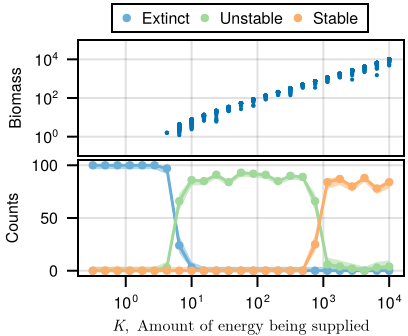

In [8]:
fig = Figure(;
    size=(double_col_width * 0.3, (double_col_width / golden_ratio) * 0.4),
    default_fig_kwargs...,
    # figure_padding=(2., 2., 2., 2.)
)

bm_yy = [0, 2, 4]
bm_ax = Axis(fig[1,1];
    xscale=log10,
    yscale=log10,
    yticks=(10. .^ bm_yy, [rich("10", superscript(string(e))) for e in bm_yy]),
    ylabel="Biomass"
)
props_ax = Axis(fig[2,1];
    xscale=log10,
    xlabel=L"K,\enspace\text{Amount of energy being supplied}",
    ylabel="Counts"
)
linkxaxes!(bm_ax, props_ax)
hidexdecorations!(bm_ax; grid=false)

hbs = df.hss_biomass
hbs = clamp.(hbs, minimum(abs, hbs), Inf)
scatter!(bm_ax, df.K, hbs;
    markersize=3,
)
ylims!(bm_ax, 1e-1, 1e5)

plot_cdf1!(props_ax, cdf; include_bad=false)

Legend(fig[-1,1],
    [
        MarkerElement(; marker=:circle, color=PaperColors.extinct1()),
        MarkerElement(; marker=:circle, color=PaperColors.unstable1()),
        MarkerElement(; marker=:circle, color=PaperColors.stable1()),
    ],
    ["Extinct", "Unstable", "Stable"];
    orientation=:horizontal,
    padding=(0., 5., 0., 0.),
    patchlabelgap=0.,
    patchsize=(15, 15),
    colgap=0.,
)

rowsize!(fig.layout, 0, Relative(0.000))
rowgap!(fig.layout, 2, -15.)
rowgap!(fig.layout, 3, 2.)

Makie.save("../../figures/fig1/li1_props.pdf", fig)

fig

# Plotting dominant states as a K vs l phase diagram

In [62]:
f = jldopen("../../cluster_env/runs/single_influx/gd2_251103_153025.jld2");
Ks, lis, rslts = make_Kli_matrix(f);

In [63]:
extrema(1 .- lis)

(0.0010000000000000009, 0.5)

In [71]:
dominant = map(rslts) do x
    am = argmax([x.extinct, x.nonext_unstable, x.nonext_stable])
    if am == 1
        PaperColors.extinct1()
    elseif am == 2
        PaperColors.unstable1()
    else
        PaperColors.stable1()
    end
end;

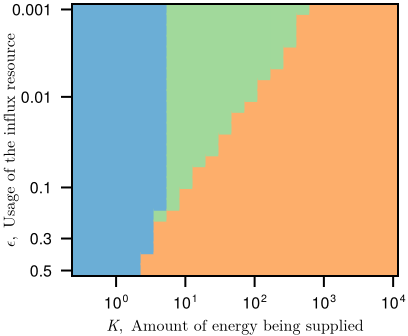

In [72]:
fig = Figure(;
    size=(double_col_width * 0.3, (double_col_width / golden_ratio) * 0.4),
    default_fig_kwargs...,
    figure_padding=(2., 5., 2., 2.),
)
ax = Axis(fig[1,1];
    xscale=log10,
)

heatmap!(ax, Ks, LeakageScale.ltox.(lis), dominant)
eps_ticks = [0.5, 0.3, 0.1, 0.01, 0.001]
ax.yticks = (LeakageScale.etox.(eps_ticks), [(@sprintf "%.2g" e) for e in eps_ticks])
ax.ylabel = L"\epsilon,\enspace\text{Usage of the influx resource}"
ax.xlabel = L"K,\enspace\text{Amount of energy being supplied}"

ax.ylabelpadding = -3.

Makie.save("../../figures/fig1/K_vs_l_pd.pdf", fig)

fig